<a href="https://colab.research.google.com/github/pavankumarbalijepalli/pr-phi2-vs-defog/blob/main/fine_tune_phi_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Exploration

### Install Necessary Modules

In [1]:
#Check the system specs
!nvidia-smi

Wed Feb  7 16:43:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
!pip install datasets
!pip install -q -U torch=='2.0.0'
!pip install -q -U accelerate=='0.25.0' peft=='0.7.1' bitsandbytes=='0.41.3.post2' trl=='0.7.4'
!pip install -q -U transformers einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

### Import EDA Modules

In [3]:
# Data Exploration Imports
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)

### Loading the dataset

In [4]:
from datasets import load_dataset

dataset = load_dataset("b-mc2/sql-create-context")
data_df = dataset['train'].to_pandas()

Generating train split: 0 examples [00:00, ? examples/s]

### Data exploration and processing

In [5]:
data_df.head()

,question,context,answer
0,How many heads of the departments are older th...,CREATE TABLE head (age INTEGER),SELECT COUNT(*) FROM head WHERE age > 56
1,"List the name, born state and age of the heads...","CREATE TABLE head (name VARCHAR, born_state VA...","SELECT name, born_state, age FROM head ORDER B..."
2,"List the creation year, name and budget of eac...","CREATE TABLE department (creation VARCHAR, nam...","SELECT creation, name, budget_in_billions FROM..."
3,What are the maximum and minimum budget of the...,CREATE TABLE department (budget_in_billions IN...,"SELECT MAX(budget_in_billions), MIN(budget_in_..."
4,What is the average number of employees of the...,CREATE TABLE department (num_employees INTEGER...,SELECT AVG(num_employees) FROM department WHER...


<Axes: xlabel='count', ylabel='difficulty'>

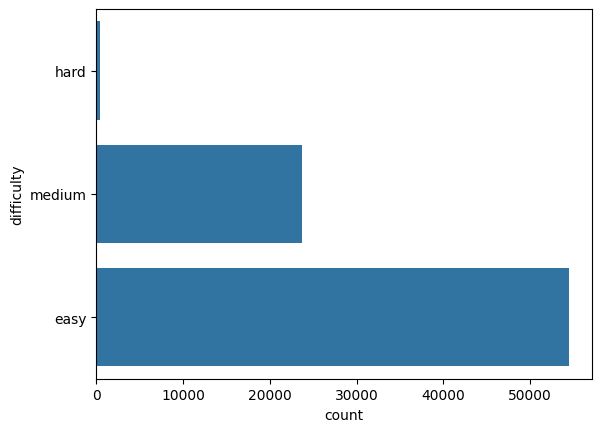

In [6]:
# Finding the complexity of the datapoint
data_df['table_count'] = data_df['context'].apply(lambda x: x.split(' ').count('CREATE'))
data_df['sub_query_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('SELECT'))
data_df['joins_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('JOIN'))
data_df['where_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('WHERE'))
data_df['group_by_count'] = data_df['answer'].apply(lambda x: x.split(' ').count('GROUP BY'))
data_df['columns_count'] = data_df['context'].apply(lambda x: list(x).count(',')) + data_df['table_count']

# Finding the complexity based on the above values
data_df['complexity'] = data_df['table_count'] + data_df['sub_query_count'] + data_df['joins_count'] + data_df['where_count'] + data_df['group_by_count'] + data_df['columns_count']
data_df = data_df.sort_values(by='complexity', ascending=False)

# Marking Difficulty based on threshold
data_df['difficulty'] = data_df['complexity'].apply(lambda x: 'easy' if x < 6 else 'medium' if x < 13 else 'hard')
sns.countplot(data_df['difficulty'])

### Train, test split

In [7]:
# Split data into train and test set also maintaining the ratio in difficulty column
train_df, test_df = train_test_split(data_df, test_size=0.1, stratify=data_df['difficulty'])
train_df, eval_df = train_test_split(train_df, test_size=0.1, stratify=train_df['difficulty'])

In [8]:
train_df.shape, test_df.shape, eval_df.shape

((63647, 11), (7858, 11), (7072, 11))

## Fine-tuning

In [9]:
from huggingface_hub import notebook_login

notebook_login()

In [10]:
def generate_prompt(data_point):
    return f"""### Task
Generate a SQL query to answer the following question:
`{data_point['question']}`

### Database Schema
The query will run on a database with the following schema:
{data_point['context']}

### Answer
Given the database schema, here is the SQL query that answers `{data_point['question']}`:
```sql
{data_point['answer']}
```""".strip()

def generate_test_prompt(data_point):
    return f"""### Task
Generate a SQL query to answer the following question:
`{data_point['question']}`

### Database Schema
The query will run on a database with the following schema:
{data_point['context']}

### Answer
Given the database schema, here is the SQL query that answers `{data_point['question']}`:
```sql""".strip()

In [11]:
X_train = pd.DataFrame(train_df.apply(generate_prompt, axis=1), columns=["text"])
X_eval = pd.DataFrame(eval_df.apply(generate_prompt, axis=1), columns=["text"])
X_test = pd.DataFrame(test_df.apply(generate_test_prompt, axis=1), columns=["text"])

In [12]:
train_dataset = Dataset.from_pandas(X_train[['text']], preserve_index=False)
eval_dataset = Dataset.from_pandas(X_eval[['text']], preserve_index=False)
test_dataset = Dataset.from_pandas(X_test[['text']], preserve_index=False)

In [13]:
train_dataset, eval_dataset, test_dataset

(Dataset({
     features: ['text'],
     num_rows: 63647
 }),
 Dataset({
     features: ['text'],
     num_rows: 7072
 }),
 Dataset({
     features: ['text'],
     num_rows: 7858
 }))

In [14]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [15]:
model_name = "microsoft/phi-2"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

print_trainable_parameters(model)

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


trainable params: 262364160 || all params: 1521392640 || trainable%: 17.24


In [16]:
def predict(X_test, model, tokenizer):
    y_pred = []
    y_act = []
    for i in tqdm(X_test.iloc):
        # print(i['answer'], '\n', i['question'], '\n', i['context'])
        prompt = generate_test_prompt(i)
        pipe = pipeline(task="text-generation",
                        model=model,
                        tokenizer=tokenizer,
                        max_new_tokens = 50,
                        temperature = 0.2,
                       )
        result = pipe(prompt, pad_token_id=pipe.tokenizer.eos_token_id)
        answer = result[0]['generated_text']

        y_pred.append(answer)
    return y_pred

In [17]:
y_pred = predict(test_df.sample(5), model, tokenizer)

5it [00:15,  3.19s/it]


In [18]:
for pred in y_pred:
  print(pred)
  print('='*20)

### Task
Generate a SQL query to answer the following question:
`What was the date for the G1 group race at Flemington?`

### Database Schema
The query will run on a database with the following schema:
CREATE TABLE table_name_98 (date VARCHAR, group VARCHAR, venue VARCHAR)

### Answer
Given the database schema, here is the SQL query that answers `What was the date for the G1 group race at Flemington?`:
```sql
SELECT date FROM table_name_98 WHERE group = 'G1' AND venue = 'Flemington';
```

### Task
Generate a SQL query to answer the following question:
`What was the date for the
### Task
Generate a SQL query to answer the following question:
`What is the number of points for the vehicle with a mp4-17d chassis earlier than 2003?`

### Database Schema
The query will run on a database with the following schema:
CREATE TABLE table_name_83 (points INTEGER, chassis VARCHAR, year VARCHAR)

### Answer
Given the database schema, here is the SQL query that answers `What is the number of points fo

In [19]:
import re

def get_num_layers(model):
    numbers = set()
    for name, _ in model.named_parameters():
        for number in re.findall(r'\d+', name):
            numbers.add(int(number))
    return max(numbers)

def get_last_layer_linears(model):
    names = []

    num_layers = get_num_layers(model)
    for name, module in model.named_modules():
        if str(num_layers) in name and not "encoder" in name:
            if isinstance(module, torch.nn.Linear):
                names.append(name)
    return names

In [23]:
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=[
    'q_proj',
    'k_proj',
    'v_proj',
    'dense',
    'fc1',
    'fc2',
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

training_arguments = TrainingArguments(
    output_dir="logs",
    num_train_epochs=2,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8, # 4
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
    evaluation_strategy="epoch"
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset.select(range(40000)),
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    args=training_arguments,
    packing=False,
    max_seq_length=512,
)

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7072 [00:00<?, ? examples/s]

In [25]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained("trained-model")

model.push_to_hub("phi2-sql-cc-qlora-test",
                  use_auth_token=True,
                  commit_message="Training Phi-2 with first 40k",
                  private=True)

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.356900,0.397507
2,0.315100,0.385444


model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pavankumarbalijepalli/phi2-sql-cc-qlora-test/commit/5f6a91463aee6060345af876b808d4e0b0b6296e', commit_message='Training Phi-2 with first 40k', commit_description='', oid='5f6a91463aee6060345af876b808d4e0b0b6296e', pr_url=None, pr_revision=None, pr_num=None)

In [26]:
#Terminate the session so we do not incur cost
from google.colab import runtime
runtime.unassign()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/runs

In [ ]:
y_pred = predict(X_test, model, tokenizer)

In [ ]:
evaluation = pd.DataFrame({'text': X_test["text"],
                           'y_true':y_true,
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)